In [1]:
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from pandas import DataFrame
import xlsxwriter

ct_sheet = pd.ExcelFile("All CTSA 2-1yr No Interpolated Samples.xlsx") 

Using TensorFlow backend.


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(419, 148)
(419, 148)
Tensor("input_1:0", shape=(None, 148), dtype=float32)
Epoch 1/150
419/419 [==============================] - 1s 2ms/step - loss: 0.2719
Epoch 2/150
419/419 [==============================] - 0s 103us/step - loss: 0.1636
Epoch 3/150
419/419 [==============================] - 0s 119us/step - loss: 0.1350
Epoch 4/150
419/419 [==============================] - 0s 128us/step - loss: 0.1252
Epoch 5/150
419/419 [==============================] - 0s 108us/step - loss: 0.1173
Epoch 6/150
419/419 [==============================] - 0s 129us/step - loss: 0.1140
Epoch 7/150
419/419 [==============================] - 0s 129us/step - loss: 0.1122
Epoch 8/150
419/419 [==============================] - 0s 124us/step - loss: 0.1095
Epoch 9/150
419/419 [==============================] - 0s 117us/step - loss: 0.1093
Epoch 10/150
419/419 [==============================] - 0s 115us/step - loss: 0.1077
Epoch 11/150
419/419 [==============================] - 0s 119us/step - loss: 0.1064


419/419 [==============================] - 0s 160us/step - loss: 0.0934
Epoch 97/150
419/419 [==============================] - 0s 150us/step - loss: 0.0929
Epoch 98/150
419/419 [==============================] - 0s 148us/step - loss: 0.0925
Epoch 99/150
419/419 [==============================] - 0s 106us/step - loss: 0.0919
Epoch 100/150
419/419 [==============================] - 0s 99us/step - loss: 0.0923
Epoch 101/150
419/419 [==============================] - 0s 99us/step - loss: 0.0920
Epoch 102/150
419/419 [==============================] - 0s 95us/step - loss: 0.0918
Epoch 103/150
419/419 [==============================] - 0s 96us/step - loss: 0.0920
Epoch 104/150
419/419 [==============================] - 0s 98us/step - loss: 0.0919
Epoch 105/150
419/419 [==============================] - 0s 94us/step - loss: 0.0918
Epoch 106/150
419/419 [==============================] - 0s 96us/step - loss: 0.0926
Epoch 107/150
419/419 [==============================] - 0s 98us/step - loss: 

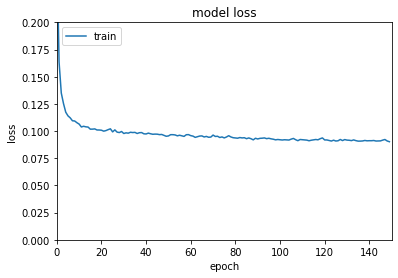

In [2]:
parsee = ct_sheet.sheet_names[0]
data = ct_sheet.parse(parsee)
data_features = data.loc[:, data.columns] 
data_features = data_features.drop(['ROI',11142,12142], axis=1)  

parsee2 = ct_sheet.sheet_names[1]
data2 = ct_sheet.parse(parsee2)
data_labels = data2.loc[:, data2.columns] 
data_labels = data_labels.drop(['ROI',11142,12142], axis=1)  
#Get rid of subject names to only have features now. #Need to remove ROIs. They don't convert to floats.
#Get rid of ctx_rh_Medial_wall and ctx_lh_Medial_wall, not needed for analysis.
scaler_filename = "IBIS_scaledCT1y.save"
scaler = joblib.load(scaler_filename)
scaled_data_1y = scaler.transform(data_features)

scaler_filename2 = "IBIS_scaledCT2y.save"
scaler2 = joblib.load(scaler_filename2)
scaled_data_2y = scaler.transform(data_labels)
print(scaled_data_1y.shape)
print(scaled_data_2y.shape)

#Size of encoded representation
#{'batch_size': 30, 'dropout': 0.2, 'encoded_layer_size': 15, 'epochs': 150, 'layer1_size': 90, 'layer2_size': 25}
input_size = 148
hidden_size = 90
hidden_size_2 = 25
encoding_dim = 15
dropout = 0.20

# Input Placeholder
input_data = Input(shape=(input_size,))
print(input_data)
# "encoded" is the encoded representation of the input
hidden_e_1 = Dense(hidden_size, activation='tanh')(input_data) 
hidden_e_2 = Dense(hidden_size_2, activation='tanh')(hidden_e_1)
dropout_layer = Dropout(dropout)(hidden_e_2)
encoded = Dense(encoding_dim, activation='tanh')(dropout_layer)
# "decoded" is the lossy reconstruction of the input
hidden_d_1 = Dense(hidden_size, activation='tanh')(encoded)
dropout_layer_d = Dropout(dropout)(hidden_d_1)
hidden_d_2 = Dense(hidden_size, activation='tanh')(dropout_layer_d)
decoded = Dense(input_size, activation='tanh')(hidden_d_2) 
# this model maps an input to its prediction
autoencoder = Model(input_data, decoded)
# configure our model to use mean_absolute_error loss function, and the Adam optimizer:
autoencoder.compile(optimizer='Adam', loss='mean_absolute_error')

ac = autoencoder.fit(scaled_data_2y, scaled_data_1y,
epochs=150,
batch_size=30,
shuffle=True)

#print(ac.history.keys())
# "Loss"
plt.plot(ac.history['loss'])
#plt.plot(ac.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, 150, 0.0, 0.2])
plt.show()

In [3]:
ct_sheet_2y = pd.ExcelFile("Data to be Interpolated.xlsx") 
parsee = ct_sheet_2y.sheet_names[5]
print(parsee)
data = ct_sheet_2y.parse(parsee)
data_features_ct2y = data.loc[:, data.columns] 
data_features_ct2y = data_features_ct2y.drop(['ROI',11142,12142], axis=1)
scaled_data_ct2y = scaler2.transform(data_features_ct2y)
print(scaled_data_ct2y.shape)

predicted_1yr_ct = autoencoder.predict(scaled_data_ct2y)

2Y CT
(20, 148)


In [4]:
print(predicted_1yr_ct)

[[ 0.64036894  0.49826038  0.4867666  ...  0.51650256  0.49842614
   0.44277075]
 [-0.2012892  -0.00967454  0.2363285  ... -0.1278462  -0.26451504
   0.15742408]
 [-0.09413803  0.03240644  0.18332168 ... -0.054509   -0.24928217
   0.10972574]
 ...
 [ 0.05405745  0.18949957  0.25593367 ...  0.05865019 -0.17421533
   0.13336399]
 [-0.12215582  0.08639398  0.29187968 ... -0.05402178 -0.18330733
   0.1513718 ]
 [-0.05644982  0.1146277   0.17949614 ... -0.00806254 -0.18621174
   0.1498978 ]]


In [5]:
df = pd.DataFrame(predicted_1yr_ct)
df.to_excel("Interpolated CT 1y.xlsx", index=False)

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0.640369,0.498260,0.486767,0.679340,0.647836,0.771028,0.580125,0.523624,0.549084,0.531644,...,0.622004,0.501568,0.403593,0.462480,0.552103,0.807491,0.465693,0.516503,0.498426,0.442771
1,-0.201289,-0.009675,0.236328,0.110132,-0.172074,0.404189,0.214570,-0.067842,0.175427,0.096374,...,0.120351,0.302310,-0.043910,-0.032883,0.230865,0.295892,-0.370035,-0.127846,-0.264515,0.157424
2,-0.094138,0.032406,0.183322,0.126899,-0.064361,0.382030,0.165874,-0.175117,0.090313,0.019391,...,0.063754,0.200735,-0.073776,-0.006355,0.227656,0.310215,-0.357703,-0.054509,-0.249282,0.109726
3,-0.011933,0.209546,0.390546,0.284583,-0.032678,0.486978,0.246892,0.073225,0.347454,0.301431,...,0.358144,0.414768,0.137315,0.065802,0.288848,0.458564,-0.155610,0.018711,-0.079966,0.196639
4,-0.214126,-0.075196,0.160270,0.019380,-0.189347,0.335372,0.152731,-0.167334,0.141346,0.036927,...,0.021591,0.279329,-0.116226,-0.066177,0.192095,0.237390,-0.378087,-0.118446,-0.299459,0.082146
5,-0.151869,-0.046057,0.090153,0.064909,-0.165846,0.407301,0.169332,-0.152404,0.173825,0.129604,...,0.076798,0.342561,-0.142221,-0.062837,0.155987,0.316728,-0.330756,-0.080629,-0.259460,0.107445
6,-0.072445,0.068676,0.241184,0.208676,-0.090794,0.416872,0.188064,-0.091904,0.210273,0.144063,...,0.156309,0.334948,-0.045736,0.023010,0.227651,0.354055,-0.269043,-0.004039,-0.141698,0.169338
7,-0.206959,-0.022644,0.143691,0.025612,-0.184921,0.353305,0.173394,-0.158910,0.160875,0.065130,...,0.063121,0.288638,-0.114977,-0.069967,0.184836,0.243122,-0.381842,-0.129778,-0.315882,0.075580
8,-0.183748,-0.086120,0.141629,0.077677,-0.165167,0.368934,0.190655,-0.174623,0.092404,0.082492,...,0.079077,0.281373,-0.122718,-0.025894,0.200144,0.242645,-0.331921,-0.119746,-0.251601,0.148905
9,-0.141157,0.024823,0.197338,0.103670,-0.137034,0.392542,0.208691,-0.113078,0.189630,0.108835,...,0.129487,0.318857,-0.084809,-0.021882,0.208574,0.278443,-0.354680,-0.079359,-0.227279,0.123877
